In [11]:
import pandas as pd 
import matplotlib.pyplot as plt 
import pathlib
import os 
import regex as re 

%matplotlib inline 

## Analyzing research paper data

In [12]:
research = "research_paper/Train_Labels"
research_files = [str(file) for file in pathlib.Path(os.path.join(os.getcwd(), research)).glob("*.data")]

In [13]:
# Files containing gibbon call starts with g_
re.search("g_.+\.data", research_files[0])

<regex.Match object; span=(55, 89), match='g_HGSM3AC_0+1_20160309_055600.data'>

In [14]:
with open(research_files[0], "r") as f:
    research_df = pd.read_csv(f)

research_columns = research_df.columns

In [15]:
research_df = pd.DataFrame(columns = research_columns)
research_df

,Start,End,Duration,Type,Notes


In [16]:
for file in research_files:
    if re.search("g_.+\.data", file):
        with open(file, "r") as f:
            tmp_research = pd.read_csv(f)
            research_df = pd.concat([research_df, tmp_research], axis = 0)

In [17]:
# Similar to source code
research_df.Notes.fillna(research_df.Type.astype(str), inplace = True)
research_df["Notes"] = research_df.Notes.str.extract("(\d+)")
research_df.drop(["Type"], axis = 1, inplace = True)

In [18]:
print(f"Research paper's max duration: {max(research_df['Duration'].tolist())}s")
print(f"Research paper's min duration: {min(research_df['Duration'].tolist())}s")

Research paper's max duration: 8s
Research paper's min duration: -4s


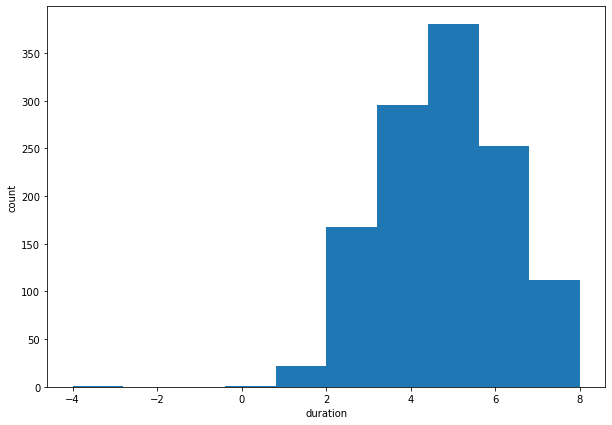

In [19]:
plt.figure(figsize = (10, 7))
plt.hist(research_df["Duration"].tolist())
plt.ylabel("count")
plt.xlabel("duration")
plt.show()

## Loading label data

In [11]:
folder = "Selection Tables"
files = [str(file) for file in pathlib.Path(os.path.join(os.getcwd(), folder)).glob("*.txt")]

In [12]:
# Quick way to extract the columns of a dataframe. 
with open(files[0], "r") as file:
    df = pd.read_csv(file, delimiter = "\t")

columns = [column for column in df.columns]

In [13]:
df = pd.DataFrame(columns = columns)

In [14]:
for file in files:
    with open(file, "r") as f:
        tmp_df = pd.read_csv(f, delimiter = "\t")
        df = pd.concat([df, tmp_df], axis = 0)


In [15]:
df.drop(columns = ["Selection", "View", "Channel", "Begin File"], inplace = True)

In [16]:
df.columns = ["Start", "End", "Low", "High", "Path", "Label"]
df.head()

,Start,End,Low,High,Path,Label
0,0.269477,3.934359,1002.4,1806.2,D:\Fauna & Flora International\VietnamAudioSto...,bird
1,8.299880,11.264122,1091.7,1667.3,D:\Fauna & Flora International\VietnamAudioSto...,mm
2,21.679146,23.296005,1240.5,1578.0,D:\Fauna & Flora International\VietnamAudioSto...,bird
3,29.170596,32.619896,1111.5,1647.4,D:\Fauna & Flora International\VietnamAudioSto...,mm
4,26.960887,27.877108,1220.7,1439.0,D:\Fauna & Flora International\VietnamAudioSto...,other


In [17]:
# Copied from helper/extract.py
def convertPath(path: str):
    '''
    * Purpose: Convert a path to absolute path.
    '''
    relative_path = re.findall("Raw Audio Files.+", path)[0]
    return os.path.join(os.getcwd(), re.sub("\((.)*\)", 
                    "(September to October 2020)", relative_path))

df["Path"] = df["Path"].apply(convertPath)

In [19]:
test = df["Path"].iloc[0]

In [20]:
test

'D:\\developer\\python\\gibbon\\Raw Audio Files\\Phase 2 (September to October 2020)\\D1\\01\\01b\\20200929_032722.WAV'

In [21]:
test.split("\\")[-1][:test.find("WAV")]

'20200929_032722.WAV'

## Analysis

In [116]:
print(f"Number of data per type:\n{df['Label'].value_counts().to_dict()}")

Number of data per type:
{'sc': 2734, 'bird': 2577, 'insect': 1219, 'mm': 900, 'gc': 118, 'other': 25, 'nothing': 1, 'human': 1}


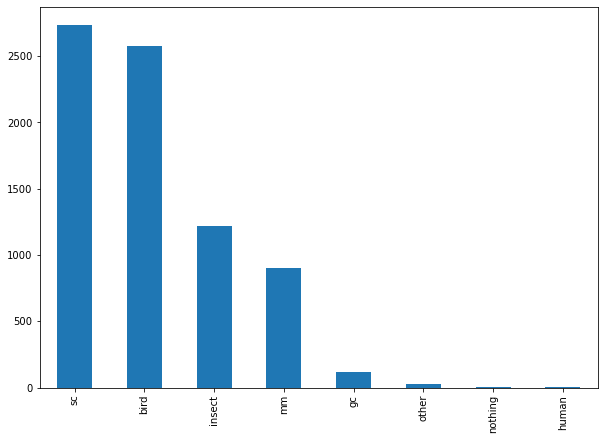

In [35]:
df["Label"].value_counts().plot(kind = "bar", figsize = (10, 7))
plt.show()

In [ ]:
# Drop? 
# df.drop((df["Label"] == "human") | (df["Label"] == "nothing") | (df["Label"] == "other").index, inplace = True)

In [36]:
# Counting gibbon class and non-gibbon class
df["Type"] = df["Label"].apply(lambda x: 1 if x in ["sc", "mm", "gc"] else 0)

In [37]:
# Gibbon class and non-gibbon class are almost equal
print(dict(df["Type"].value_counts()))

{0: 3850, 1: 3752}


### Analysing call duration
This is important when we use the rolling window approach, per research paper implementation.

#### Gibbon calls

In [50]:
gibbon = df[df["Type"] == 1]
gibbon["Duration"] = gibbon["End"] - gibbon["Start"]

C:\Users\forev\miniconda3\envs\gibbon\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [109]:
print(f"Average calling duration: {gibbon.Duration.mean()}")
gibbon_count = gibbon["Duration"].value_counts().sort_values(ascending = False).reset_index()
gibbon_count.columns = ["Duration", "Count"]
gibbon_count

Average calling duration: 2.211103972929638


,Duration,Count
0,0.916054,27
1,0.683745,24
2,0.724085,24
3,0.800305,17
4,0.883338,17
...,...,...
2307,2.547770,1
2308,1.526835,1
2309,7.606667,1
2310,0.971622,1


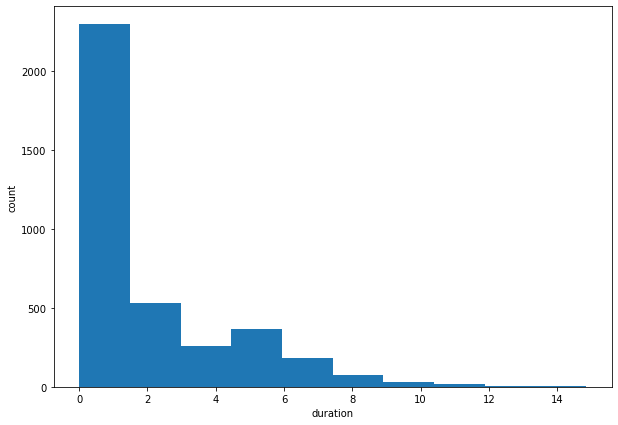

In [60]:
gibbon_duration = gibbon["Duration"].tolist()

fig, ax = plt.subplots(figsize = (10, 7))

ax.hist(gibbon_duration)
ax.set(xlabel = "duration", ylabel = "count")
plt.show()

Are there differences between the type of calls and their duration?

In [102]:
print(f"Different types of gibbon call and their duration:\n{gibbon.groupby('Label')['Duration'].mean().to_dict()}")

Different types of gibbon call and their duration:
{'gc': 8.419946853847458, 'mm': 4.677530884615555, 'sc': 1.1312108930226774}


In [106]:
print(f"Number of data points per type of call:\n{gibbon['Label'].value_counts().to_dict()}")

Number of data points per type of call:
{'sc': 2734, 'mm': 900, 'gc': 118}


#### Non-gibbon calls

In [107]:
non_gibbon = df[df["Type"] == 0]
non_gibbon["Duration"] = non_gibbon["End"] - non_gibbon["Start"]

C:\Users\forev\miniconda3\envs\gibbon\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [108]:
print(f"Average calling duration: {non_gibbon.Duration.mean()}")
non_gibbon_count = non_gibbon["Duration"].value_counts().sort_values(ascending = False).reset_index()
non_gibbon_count.columns = ["Duration", "Count"]
non_gibbon_count

Average calling duration: 1.1047267876511684


,Duration,Count
0,0.724085,21
1,0.743140,21
2,0.571646,19
3,0.952744,19
4,0.705030,17
...,...,...
2131,0.769214,1
2132,0.702066,1
2133,0.364534,1
2134,0.685975,1


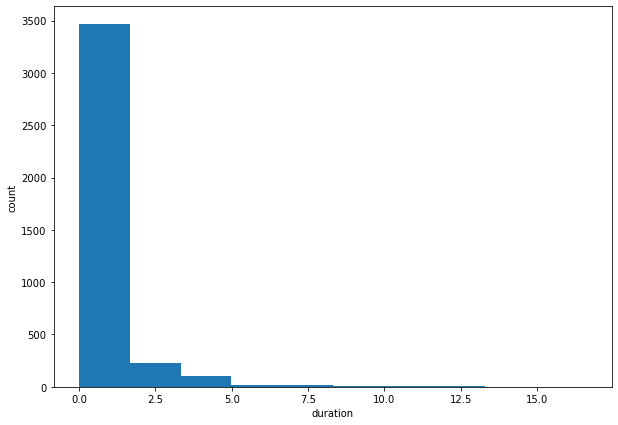

In [110]:
non_gibbon_duration = non_gibbon["Duration"].tolist()

fig, ax = plt.subplots(figsize = (10, 7))

ax.hist(non_gibbon_duration)
ax.set(xlabel = "duration", ylabel = "count")
plt.show()

In [111]:
print(f"Different types of gibbon call and their duration:\n{non_gibbon.groupby('Label')['Duration'].mean().to_dict()}")

Different types of gibbon call and their duration:
{'bird': 1.2850583430795457, 'human': 3.8535155000000145, 'insect': 0.7007783448408521, 'nothing': 1.027397045999976, 'other': 2.2391466933200004}


In [117]:
print(f"Number of data points per type of call:\n{non_gibbon['Label'].value_counts().to_dict()}")

Number of data points per type of call:
{'bird': 2577, 'insect': 1219, 'other': 25, 'human': 1, 'nothing': 1}


**TODO**
* Figure an approach